In [1]:
# Notebook to interact with OT2 pipetting robot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import realpy.UCB.ucb as ucb
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import os
import warnings

from GA_experiment.Prepare_Data_Functions import load_df, subtract_baseline, normalize_df, delete_rows

# Initialize and process target data

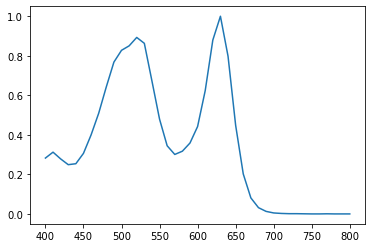

In [2]:
df = load_df('Target_spectra.xlsx')
df = subtract_baseline(df, 'A2')
df = normalize_df(df)
df = df.drop(['A2'], axis = 1)
current_gen_spectra = np.asarray(df)
wavelength = current_gen_spectra[:,0]
TARGET = current_gen_spectra[:,1:].T
plt.plot(wavelength.reshape(-1,1), TARGET.T)

# Initialize Environment

In [3]:
class Environment(object):
    def __init__(self, target):
        self.target = target
   
    def get_cos_sim(self, target, y):
        """Similarity metric to maximize."""
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def write_actions(self, actions, time_step):
        """Write batch of actions to csv file."""
        df = pd.DataFrame(actions, columns=['1','2','3'])
        df.to_csv(f'Batch_{time_step + 1}.csv')
        
    def spectra_from_conc(self):
        """Read and write data."""
        print("\ncsv file written with robot instructions. Waiting for experiment...")
        print('What is the csv file name of the experimental results?')
        file_name = input()
        if os.path.exists(file_name):
            #df = pd.read_csv(file_name)
            #result = result.drop(['Unnamed: 0'], axis = 1)
            df = load_df(file_name)
            df = subtract_baseline(df, 'B8')
            df = normalize_df(df)
            df = df.drop(['B8'], axis = 1)
            current_gen_spectra = np.asarray(df)
            wavelength = current_gen_spectra[:,0]
            result = current_gen_spectra[:,1:].T
            return np.array(result)
        elif file_name == 'END' or file_name == 'STOP':
            warnings.warn("Ending experiment.")
        else:
            warnings.warn(f'{file_name} does not exist')
             
    def sample(self):
        results = self.spectra_from_conc()
        metrics = []
        for result in results:
            metric = self.get_cos_sim(self.target, result)
            metrics.append(metric)
        return np.array(metrics)

In [4]:
env = Environment(TARGET)

# Rough Draft of new GPBUCB

In [5]:
class newBatchGPUCB(ucb.BatchGPUCB):
    """Batched Guassian Process Upper Confidence Bound agent."""

    def __init__(self, *args, **kwargs):
        super(newBatchGPUCB, self).__init__(*args, **kwargs)
        self.first = True
        self.exclude = []
    def learn(self):
        np.random.seed(2)
        if self.T == 0:
            self.london_hypercube_sample()
        else:
            best_idxs = []
            for i in range(self.batch_size):
                best_idx = self.argsort_ucb()
                best_idxs.append(best_idx.item())
                gp = sklearn.gaussian_process.GaussianProcessRegressor()
                self.other_sample(best_idx)
                #print(self.X)
                #print(np.array(self.X))
                X = np.array(self.X).reshape(-1, self.input_dimension)
                Y = np.array(self.Y).reshape(-1)
                gp.fit(X, Y)
                self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)  # 4

            #print(best_idxs)
            self.batch_sample(self.X_grid[best_idxs])
        gp = sklearn.gaussian_process.GaussianProcessRegressor()
        X = np.array(self.X).reshape(-1, self.input_dimension)
        Y = np.array(self.Y).reshape(-1)
        gp.fit(X, Y)
        self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)  # 4
        # increase time step
        self.T = self.T + 1  # 5
        self.first = True
        return None
    
    def batch_sample(self, xs):
        """
        Sample the sets of input in xs using the environment object.
        Save each input and output pair to the X and Y attributes,
        respectively.

        Arguments:
            xs - The set of input parameters to sample.
                type == list or array of tuples
        """
        self.X = self.X[0:-batch_size]
        self.Y = self.Y[0:-batch_size]

        
        
        self.environment.write_actions(xs, self.T)
        ys = self.environment.sample()
        for x in xs:
            self.X.append(x)
        for y in ys:
            self.Y.append(y)
        return None
    
    
    def other_sample(self, x):
        self.X.append(self.X_grid[x].tolist())
        self.Y.append(self.mu[x])

    
    def argsort_ucb(self):
        """Return the indices of the batch with the highest UCB."""
        argsort_arr = np.flip(np.argsort(self.mu + self.sigma *
                                         np.sqrt(self.beta)))
        i=0
        idx = argsort_arr[i]
        print(self.exclude)
        print(idx)
        while idx in self.exclude:
            print('excluded')
            i += 1
            idx = argsort_arr[i]
        self.exclude.append(idx)
        return idx

# Initialize experimental constraints

In [6]:
#constraints
min_conc = 0.05
max_conc = 1

# parameter space
N = 20  # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs, coeffs)

# Initialize agent

In [7]:
batch_size = 15
agent = newBatchGPUCB(batch_size, param_space, env, beta=1.5)

# Learn

In [8]:
# training loop
epochs = 10
for i in range(epochs):
    agent.learn()


csv file written with robot instructions. Waiting for experiment...
What is the csv file name of the experimental results?
Iteration_1.xlsx


/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[]
7999
[7999]
399
[7999, 399]
294
[7999, 399, 294]
160
[7999, 399, 294, 160]
395
[7999, 399, 294, 160, 395]
355
[7999, 399, 294, 160, 395, 355]
333
[7999, 399, 294, 160, 395, 355, 333]
775
[7999, 399, 294, 160, 395, 355, 333, 775]
375
[7999, 399, 294, 160, 395, 355, 333, 775, 375]
375
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376]
355
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354]
355
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356]
354
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396]
355
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754]
375
excluded
excluded
excluded
excluded
excluded

csv file written with robot instructions. Waiting for experiment...
What is the csv file name of the experimental results?
Iteration_2.xlsx


/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334]
7619
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619]
7619
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380]
7619
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639]
7619
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618]
7619
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219]
7619
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659]
7619
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638]
7619
excluded
excluded
excluded
excluded
ex

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781]
7619
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded

csv file written with robot instructions. Waiting for experiment...
What is the csv file name of the experimental results?
Iteration_3.xlsx


/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218]
7990
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990]
7990
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989]
7990
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991]
7990
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970]
7990
excluded
excluded
excluded
excluded
[7999, 399, 294, 160

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949]
7990
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951]
7990
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948]
7990
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
exclude

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987]
5999
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999]
5999
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599]
5999
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 79

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619]
5999
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818]
5999
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419]
280
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280]
280
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 519

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040]
280
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620]
280
excluded
excluded
excluded
excluded
excluded
exclude

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280]
6260
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220]
6240
excluded
excluded


/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200]
6240
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920]
2491
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900,

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111]
2491
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092]
2491
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 321

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891]
1379
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891, 1379, 1359, 1399, 979, 1339]
1379
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375:

[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891, 1379, 1359, 1399, 979, 1339, 1759, 1779, 959, 999, 1799]
1379
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 798

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891, 1379, 1359, 1399, 979, 1339, 1759, 1779, 959, 999, 1799, 1419, 1739, 800, 1019, 1200, 204, 205, 184, 185, 224]
204
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891, 1379, 1359, 1399, 979, 1339, 1759, 1779, 959, 999, 1799, 1419, 1739, 800, 1019, 1200, 204, 205, 184, 185, 224, 225, 604, 584, 624]
204
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970,

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239, 780, 382, 383, 7617, 781, 7218, 7990, 7989, 7991, 7970, 7969, 7988, 7971, 7992, 7968, 7950, 7949, 7951, 7948, 7972, 7987, 5999, 5599, 3219, 5998, 6399, 2819, 5598, 5199, 3619, 2818, 6398, 3218, 5997, 5979, 2419, 280, 260, 300, 240, 680, 660, 700, 640, 320, 220, 1060, 1080, 1040, 620, 1100, 6260, 6240, 5840, 5820, 5860, 6280, 6220, 5880, 5800, 6300, 5900, 6200, 6320, 5420, 5920, 2491, 2511, 2492, 2510, 2091, 2111, 2490, 2110, 2512, 2090, 2092, 2112, 2109, 2911, 2891, 1379, 1359, 1399, 979, 1339, 1759, 1779, 959, 999, 1799, 1419, 1739, 800, 1019, 1200, 204, 205, 184, 185, 224, 225, 604, 584, 624, 165, 244, 605, 164]
204
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
[7999, 399, 294, 160, 395, 355, 333, 775, 375, 376, 354, 356, 396, 754, 334, 7619, 380, 7639, 7618, 7219, 7659, 7638, 381, 7239,

/Users/Huat/opt/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [ ]:
#Batch_1_Results.csv

In [ ]:
def plot_batch_stack(Recomendations, batch_size, epochs):
    
    nrows = epochs//2
    fig, axes = plt.subplots(figsize=(10,15), nrows=nrows, ncols=2)
    fontsize = 16

    total_steps = Recomendations.shape[0]
    
    # formatting loop
    for i, ax in enumerate(axes.flatten()):
        # ticks
        ax.tick_params(direction='out', width=2, length=8)
        ax.tick_params(direction='out', which='minor', width=1, length=5)
        ax.set_yticks([])
        
        if i in [epochs-2, epochs-1]:
            ax.set_xticks(np.arange(300, 701, 100))
            ax.tick_params(axis='x', labelsize=fontsize+2)
            ax.set_xlabel("Wavelength", fontsize=fontsize+6)
        else:
            ax.set_xticks([])
     
    # actually plotting loop
    for i, ax in enumerate(axes.flatten()):
        # target
        ax.plot(wavelength, target, 'k-', linewidth=3, label="Target")
        # get batch
        batch = i
        base = i*batch_size
        subset = Recs[base : base + batch_size]
        for action in subset:
            low_action = add_systematic_low_to_actions(action)
            ax.plot(wavelength, spectra_from_conc(low_action, RED, GREEN, BLUE), '-',
                 c=action, alpha=0.4)
        # setting legend as batch label
        legend = ax.legend([f'Batch {i+1}'], fontsize=fontsize+4, handlelength=0,
                           handletextpad=0, fancybox=True,)
        for item in legend.legendHandles:
            item.set_visible(False)

    plt.subplots_adjust(hspace=0.0, wspace=0.05)
    plt.show()

In [11]:
def plot_batch(Results, actions, wavelength, target, batch_num):
    
    fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1)
    fontsize = 16
    
    # formatting loop
    ax.tick_params(direction='out', width=2, length=8)
    ax.tick_params(direction='out', which='minor', width=1, length=5)
    ax.set_yticks([])
        
    ax.set_xticks(np.arange(300, 701, 100))
    ax.tick_params(axis='x', labelsize=fontsize+2)
    ax.set_xlabel("Wavelength", fontsize=fontsize+6)

    # target
    ax.plot(wavelength, target, 'k-', linewidth=3, label="Target")
    for i, spectrum in enumerate(Results):
        ax.plot(wavelength, spectrum, '-', c=actions[i], alpha=0.4)
    # setting legend as batch label
    legend = ax.legend([f'Batch {batch_num}'], fontsize=fontsize+4, handlelength=0,
                        handletextpad=0, fancybox=True,)
    for item in legend.legendHandles:
        item.set_visible(False)

    plt.subplots_adjust(hspace=0.0, wspace=0.05)
    plt.show()

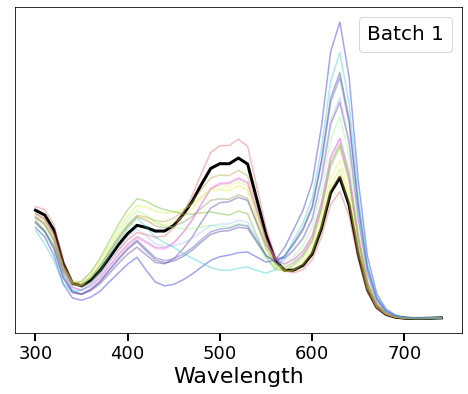

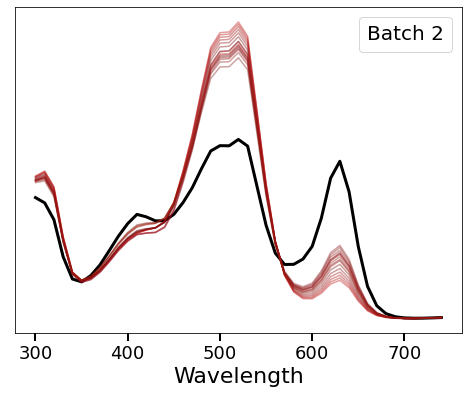

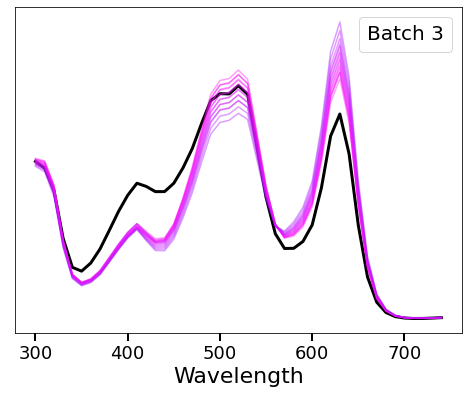

In [14]:
for i in range(1,4):
    Results = pd.read_csv(f'Batch_{i}_Results.csv')
    actions = pd.read_csv(f'Batch_{i}.csv')
    Results = np.array(Results)[:,1:]
    actions = np.array(actions)[:,1:]
    plot_batch(Results, actions, wavelength, TARGET, i)